# PAPILA - Glaucoma classificacion

<hr>

# Import neccesary libraries

In [1]:
%cd /content/drive/My Drive/papila_img/

/content/drive/My Drive/papila_img


In [3]:
!pip install mlflow

In [4]:
#   basic packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random

#   img packages

from PIL import Image
from skimage.transform import resize

#   ml packages

from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split

#   deep learning packages

import tensorflow as tf
from keras.metrics import Precision
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten,Conv2D,Dropout,AveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#   mlops packages

import mlflow
# import mlflow.pyfunc

# %%

# fixed variables, setup seeds and filter warnings messages

ROOT_DIR = '../'

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

# Define main functions, extract from paper HelpCode section

In [5]:
def _fix_df(df):
    """Prepare the Data Frame to be readable
    """
    df_new = df.drop(['ID'], axis=0)
    df_new.columns = df_new.iloc[0,:]
    df_new.drop([np.nan], axis=0, inplace=True)
    df_new.columns.name = 'ID'
    return df_new

def read_clinical_data(abs_path='../'):
    """Return excel data as pandas Data Frame
    """
    df_od = pd.read_excel(abs_path + 'ClinicalData/patient_data_od.xlsx', index_col=[0])
    df_os = pd.read_excel(abs_path + 'ClinicalData/patient_data_os.xlsx', index_col=[0])
    return _fix_df(df=df_od), _fix_df(df=df_os)

# Read clinical data

In [6]:
df_od, df_os = read_clinical_data('./')

# Feature engineering

*   OD -> Oculus Dexter(right eye)
*   OS -> Oculus Sinister (left eye)



In [7]:
def create_token_id(df_sample,direction = 'OS'):
    # reminder that: OD -> Oculus Dexter(right eye) and OS -> Oculus Sinister (left eye)

    df_sample = df_sample.copy()
    df_sample = df_sample.reset_index().rename({'index':'token_id'},axis = 1)

    df_sample['token_id'] = df_sample['token_id'].apply(lambda x: 'RET' + x.replace('#','').strip() + direction+'.jpg')
    df_sample['eye_side'] = direction

    return df_sample

# Join both eyes set

In [8]:
df_test_os = create_token_id(df_os,'OS')
df_test_od = create_token_id(df_od,'OD')

df_join_data = pd.concat([df_test_os,df_test_od])

In [9]:
df_join_data.sample(10)

ID       token_id Age Gender Diagnosis dioptre_1 dioptre_2 astigmatism  \
72   RET105OS.jpg  78      0         1         1      -1.5          80   
0    RET002OD.jpg  47      0         2      0.75     -1.75          90   
193  RET239OD.jpg  47      1         0       0.5     -0.25          35   
79   RET116OS.jpg  68      1         1      3.75      -1.5          90   
158  RET203OD.jpg  68      0         0      2.25        -2          85   
235  RET285OD.jpg  58      1         0       1.5      -0.5         105   
199  RET245OS.jpg  49      1         0         1     -0.75         110   
63   RET090OS.jpg  72      0         1      2.25     -2.25          90   
84   RET123OS.jpg  74      0         1      0.25     -0.75         125   
63   RET090OD.jpg  72      0         1         2      -1.5          95   

ID  Phakic/Pseudophakic Pneumatic Perkins Pachymetry Axial_Length  VF_MD  \
72                    1       NaN      20        563        25.43  -6.75   
0                     0        21     NaN        586        23.64  -0.07   
193                   0        14     NaN        558        22.33    NaN   
79                    1       NaN      17        NaN        21.05 -10.36   
158                   0        19     NaN        571        23.83    NaN   
235                   0        14     NaN        482        22.73    NaN   
199                   0        16     NaN        493        22.63    NaN   
63                    1       NaN      17        572        24.07   -1.4   
84                    1       NaN      24        595        24.25 -22.69   
63                    1       NaN      28        573        23.87  -4.31   

ID  eye_side  
72        OS  
0         OD  
193       OD  
79        OS  
158       OD  
235       OD  
199       OS  
63        OS  
84        OS  
63        OD

In [10]:
df_join_data.Diagnosis.value_counts(normalize = True)

0    0.682377
1    0.178279
2    0.139344
Name: Diagnosis, dtype: float64

# Class availabes

*   0, healthy
*   1, glaucoma
*   2, suspicious






In [11]:
# based on the test #2 from paper experiments, remove suspicious class (2)

df_join_data['Diagnosis'] = df_join_data['Diagnosis'].replace(2,0)

# Get X and y datasets

In [12]:
# def x_and_y_dataset(lower_index,upper_index,eye_class = 'both'):
def x_dataset(df_sample):
    df_sample = df_sample.copy()
    # if eye_class == 'both':
    #     df_sample = df_join_data.copy() # in this fuction, df_join_data is a global variable
    # else:
    #     df_sample = df_join_data[df_join_data.eye_side == eye_class]

    list_to_tensor,list_not_available = [],[]

    # for i, row in df_sample.iloc[lower_index:upper_index,:].iterrows():
    for i, row in df_sample.iterrows():
        try:
            # resize img to 224 x 224 because, RESNET50 was trained with this configuration
            resize_sample = resize(np.array(Image.open("FundusImages/" + row['token_id'])), (224, 224))
            list_to_tensor.append(resize_sample)
        except:
            print(f'the sample {row["token_id"]} is not available')
            list_not_available.append(row["token_id"])

    X_set = np.array(list_to_tensor)
    # y_set = df_join_data.iloc[lower_index:upper_index,:].Diagnosis
    return X_set
    # return X_set,y_set

# plot eyes sample

def visualize_four_samples(X_set):
    _, ax = plt.subplots(2, 2, figsize=(10, 10))
    index = 0

    for i in range(2):
        for j in range(2):
            cell = ax[i][j]
            cell.set_xticks([])
            cell.set_yticks([])
            cell.grid(False)
            cell.imshow(X_set[index], cmap='gray')
            index += 1

    plt.show()

In [13]:
df_join_data.Diagnosis.value_counts(normalize = True)

0    0.821721
1    0.178279
Name: Diagnosis, dtype: float64

In [14]:
df_join_data.Diagnosis.value_counts(normalize = False)

0    401
1     87
Name: Diagnosis, dtype: int64

In [15]:
df_healty_sample = df_join_data[df_join_data.Diagnosis == 0].sample(87, random_state = 42)

In [16]:
df_glaucoma = df_join_data[df_join_data.Diagnosis == 1]

In [17]:
df_balanced_set = pd.concat([df_healty_sample, df_glaucoma])

In [18]:
df_balanced_set.head()

ID       token_id Age Gender  Diagnosis dioptre_1 dioptre_2 astigmatism  \
125  RET168OD.jpg  71      0          0      0.25      -1.5          87   
121  RET163OD.jpg  61      1          0      1.75     -0.75          13   
71   RET104OS.jpg  57      0          0         1      -0.5         175   
27   RET034OD.jpg  57      1          0      0.75      -0.5          80   
137  RET181OS.jpg  52      0          0         0      -0.5          83   

ID  Phakic/Pseudophakic Pneumatic Perkins Pachymetry Axial_Length VF_MD  \
125                   1        14     NaN        531        23.78   NaN   
121                   1        18     NaN        602        22.59   NaN   
71                    1        16      15        493        23.58  0.22   
27                    1        18     NaN        525        23.87   NaN   
137                   0        18     NaN        541        23.85   NaN   

ID  eye_side  
125       OD  
121       OD  
71        OS  
27        OD  
137       OS

In [19]:
df_balanced_set.Diagnosis.value_counts() # balanced dataset

0    87
1    87
Name: Diagnosis, dtype: int64

In [20]:
X = df_balanced_set.drop('Diagnosis',axis = 1)
y = df_balanced_set['Diagnosis']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
y_train.mean()

0.5035971223021583

In [23]:
y_test.mean()

0.4857142857142857

# Extract 150 observations for train, 50 for test and 20 for validation - left eye

In [24]:
X_train_tensor = x_dataset(X_train)
X_test_tensor = x_dataset(X_test)

- Train img

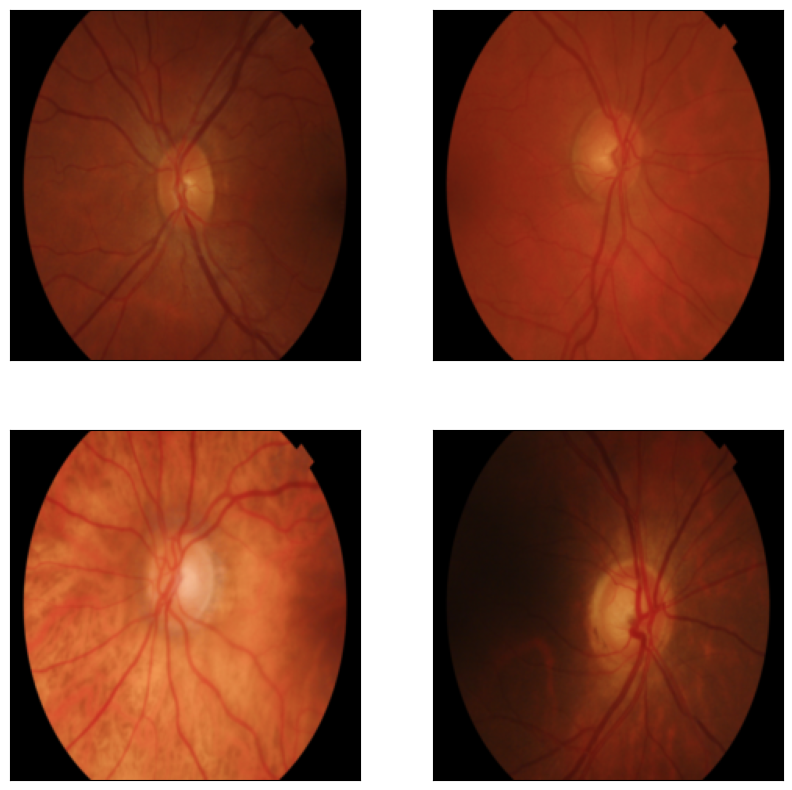

In [25]:
visualize_four_samples(X_train_tensor)

- Test img

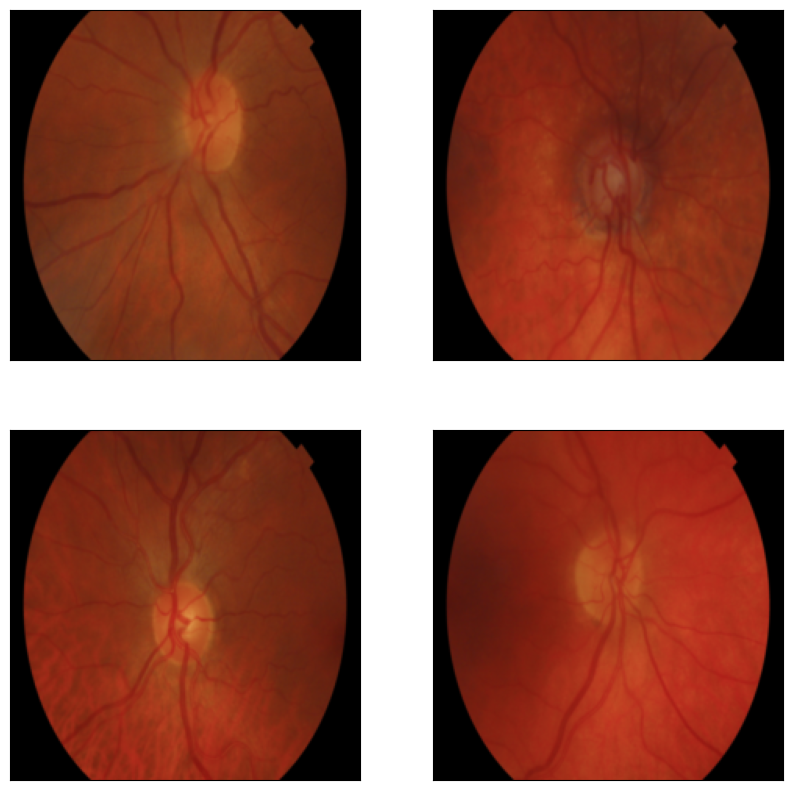

In [26]:
visualize_four_samples(X_test_tensor)

- Validation img

# Create a simple CNN-ANN

In [27]:
#   ANN - architecture

model_simple = keras.Sequential([
     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
     Conv2D(64, (3, 3), activation='relu', strides=(2, 2)),
     Conv2D(128, (3, 3), activation='relu'),
     Dropout(0.5),
     Flatten(),
     # Fully connected layers
     Dense(64, activation='relu'),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')
])

#   compile settings

model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

#   train model

model_simple.fit(X_train_tensor, y_train, epochs=50)

Epoch 1/50
5/5 [==============================] - 14s 289ms/step - loss: 0.8273 - precision: 0.5333
Epoch 2/50
5/5 [==============================] - 1s 107ms/step - loss: 0.6961 - precision: 0.5000
Epoch 3/50
5/5 [==============================] - 1s 108ms/step - loss: 0.6868 - precision: 0.5385
Epoch 4/50
5/5 [==============================] - 1s 107ms/step - loss: 0.6817 - precision: 0.5122
Epoch 5/50
5/5 [==============================] - 1s 108ms/step - loss: 0.6650 - precision: 0.6418
Epoch 6/50
5/5 [==============================] - 1s 107ms/step - loss: 0.6850 - precision: 0.6154
Epoch 7/50
5/5 [==============================] - 1s 106ms/step - loss: 0.6608 - precision: 0.5437
Epoch 8/50
5/5 [==============================] - 1s 107ms/step - loss: 0.6257 - precision: 0.6429
Epoch 9/50
5/5 [==============================] - 1s 108ms/step - loss: 0.5742 - precision: 0.6538
Epoch 10/50
5/5 [==============================] - 1s 109ms/step - loss: 0.5227 - precision: 0.7636
Epoch 11

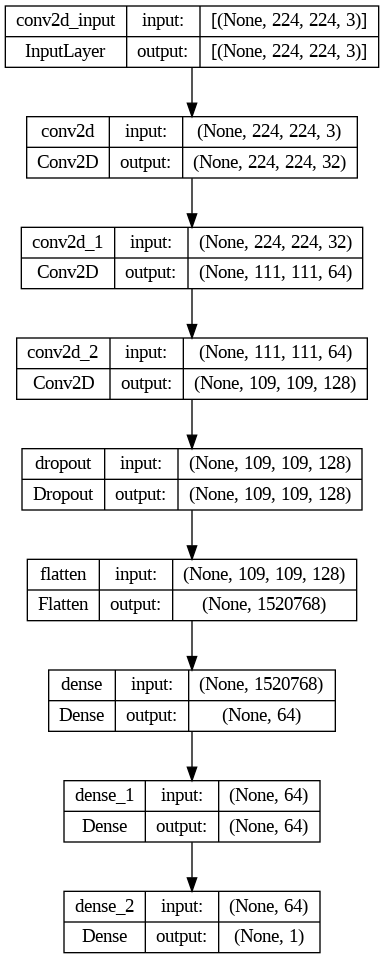

In [25]:
plot_model(model_simple, show_shapes=True)

In [28]:
model_simple.evaluate(X_train_tensor,y_train)

5/5 [==============================] - 0s 32ms/step - loss: 8.8550e-04 - precision: 1.0000


[0.0008854985353536904, 1.0]

In [29]:
model_simple.evaluate(X_test_tensor,y_test)

2/2 [==============================] - 0s 250ms/step - loss: 1.6078 - precision: 0.8462


[1.607797622680664, 0.8461538553237915]

In [30]:
y_pred_prob_ann_cnn = model_simple.predict(X_test_tensor)

2/2 [==============================] - 0s 25ms/step


In [31]:
y_pred_ann_cnn = (y_pred_prob_ann_cnn.flatten() >0.5)+0

In [32]:
accuracy_score(y_test,y_pred_ann_cnn)

0.7714285714285715

In [33]:
precision_score(y_test,y_pred_ann_cnn)

0.8461538461538461

In [35]:
recall_score(y_test,y_pred_ann_cnn)

0.6470588235294118

In [36]:
print(classification_report(y_test,y_pred_ann_cnn))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.85      0.65      0.73        17

    accuracy                           0.77        35
   macro avg       0.79      0.77      0.77        35
weighted avg       0.79      0.77      0.77        35



In [37]:
confusion_matrix(y_test, y_pred_ann_cnn)

array([[16,  2],
       [ 6, 11]])

# Precision vs Recall


In [38]:
precision_simple, recall_simple, _ = precision_recall_curve(y_test, y_pred_ann_cnn)

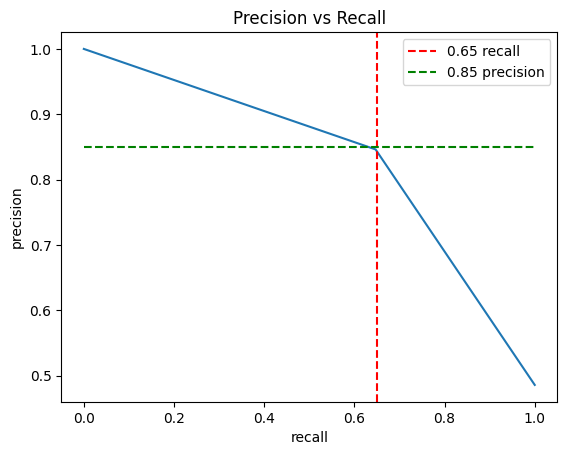

In [39]:
plt.plot(recall_simple,precision_simple)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision vs Recall')
plt.axvline(x = 0.65, linestyle = '--', color = 'r', label = '0.65 recall')
plt.hlines(y = 0.85, xmin = 0, xmax = 1, linestyle = '--',label = '0.85 precision', color = 'g')
plt.legend()
plt.show()

# ROC curve

In [40]:
fpr_simple, tpr_simple, _ = roc_curve(y_test.values, y_pred_ann_cnn)

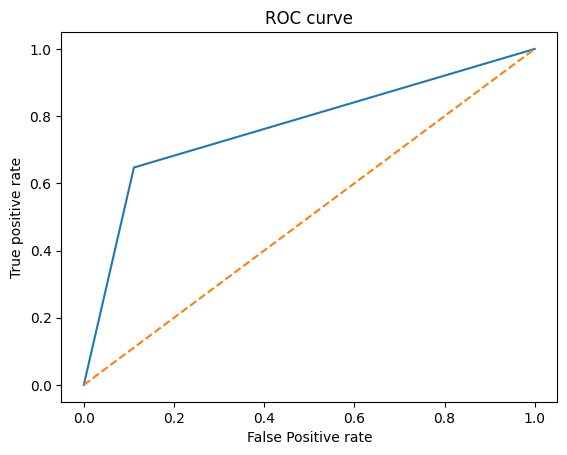

In [41]:
plt.plot(fpr_simple,tpr_simple)
plt.plot([0,1],[0,1], linestyle = '--')
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# Lenet ANN architecture

In [58]:
#   lenet architecture

model_lenet = keras.Sequential([
     Conv2D(32, (5, 5), activation='relu',padding='same',strides=(1, 1), input_shape=(224, 224, 3)),
    #  AveragePooling2D(strides = (2,2)),
     Conv2D(16, kernel_size = (5, 5), activation='relu', strides=(1, 1)),
     AveragePooling2D(strides = (2,2)),
     Conv2D(120, kernel_size = (5,5), activation='relu', strides=(1, 1)),
     Flatten(),
    #  Dense(120, activation='relu'),
     Dense(84, activation='relu'),
     Dense(1, activation='sigmoid') # Capa de salida
])


#   transform y label to categorical

# y_train_cat = tf.keras.utils.to_categorical(y_train)

#   compile settings

model_lenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=[Precision()])

#   train model

model_lenet.fit(X_train_tensor, y_train, epochs=50)

Epoch 1/30
5/5 [==============================] - 2s 120ms/step - loss: 1.7008 - precision_3: 0.4444
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 0.6927 - precision_3: 0.5000
Epoch 3/30
5/5 [==============================] - 1s 111ms/step - loss: 0.6905 - precision_3: 0.5909
Epoch 4/30
5/5 [==============================] - 1s 107ms/step - loss: 0.6992 - precision_3: 0.4961
Epoch 5/30
5/5 [==============================] - 1s 107ms/step - loss: 0.6808 - precision_3: 0.8462
Epoch 6/30
5/5 [==============================] - 1s 107ms/step - loss: 0.6592 - precision_3: 0.5955
Epoch 7/30
5/5 [==============================] - 1s 111ms/step - loss: 0.6741 - precision_3: 0.6190
Epoch 8/30
5/5 [==============================] - 1s 117ms/step - loss: 0.6874 - precision_3: 0.5478
Epoch 9/30
5/5 [==============================] - 1s 108ms/step - loss: 0.6617 - precision_3: 0.5833
Epoch 10/30
5/5 [==============================] - 1s 111ms/step - loss: 0.6392 - precision

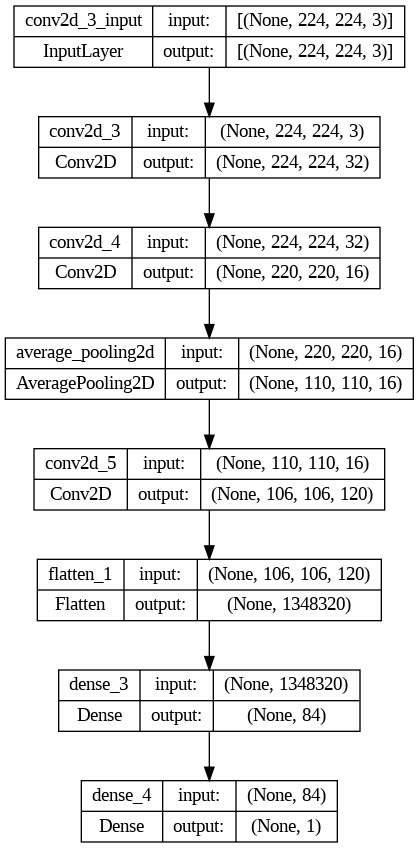

In [43]:
plot_model(model_lenet, show_shapes=True)

In [59]:
model_lenet.evaluate(X_train_tensor,y_train)

5/5 [==============================] - 0s 38ms/step - loss: 0.1157 - precision_3: 0.9583


[0.11568092554807663, 0.9583333134651184]

In [60]:
model_lenet.evaluate(X_test_tensor,y_test)

2/2 [==============================] - 0s 22ms/step - loss: 0.4611 - precision_3: 0.9231


[0.46105819940567017, 0.9230769276618958]

In [66]:
model_lenet.save('model_lenet.h5')

In [61]:
y_pred_prob_lenet = model_lenet.predict(X_test_tensor)

2/2 [==============================] - 0s 31ms/step


In [62]:
y_pred_lenet = (y_pred_prob_lenet.flatten() >0.5)+0

In [63]:
accuracy_score(y_test,y_pred_lenet)

0.8285714285714286

In [64]:
precision_score(y_test,y_pred_lenet)

0.9230769230769231

In [65]:
recall_score(y_test,y_pred_lenet)

0.7058823529411765

In [66]:
print(classification_report(y_test,y_pred_lenet))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.92      0.71      0.80        17

    accuracy                           0.83        35
   macro avg       0.85      0.83      0.83        35
weighted avg       0.85      0.83      0.83        35



In [68]:
confusion_matrix(y_test, y_pred_lenet)

array([[17,  1],
       [ 5, 12]])

In [69]:
precision_lenet, recall_lenet, _ = precision_recall_curve(y_test, y_pred_lenet)

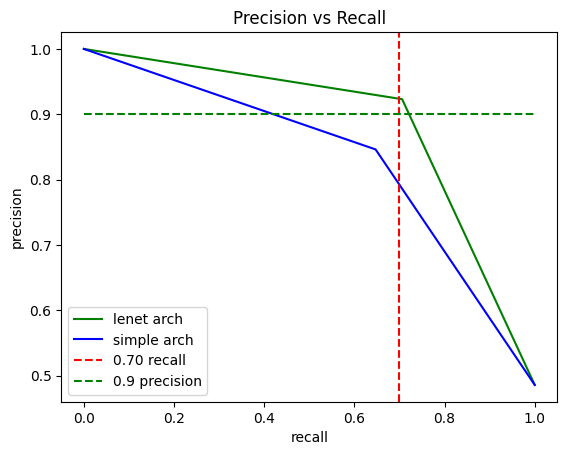

In [71]:
plt.plot(recall_lenet,precision_lenet, label = 'lenet arch', color = 'g')
plt.plot(recall_simple,precision_simple, label = 'simple arch', color = 'b')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision vs Recall')
plt.axvline(x = 0.70, linestyle = '--', color = 'r', label = '0.70 recall')
plt.hlines(y = 0.9, xmin = 0, xmax = 1, linestyle = '--',label = '0.9 precision', color = 'g')
plt.legend()
plt.show()

In [85]:
fpr_lenet, tpr_lenet, _ = roc_curve(y_test.values, y_pred_lenet)

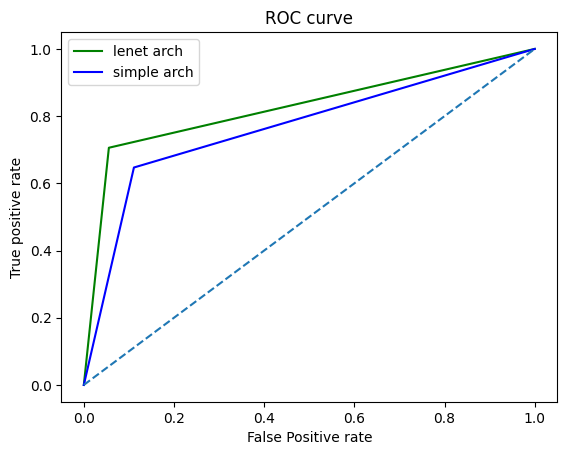

In [87]:
plt.plot(fpr_lenet,tpr_lenet, label = 'lenet arch', color = 'g')
plt.plot(fpr_simple,tpr_simple, label = 'simple arch', color = 'b')
plt.plot([0,1],[0,1], linestyle = '--')
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

# Resnet50

In [81]:
# ann architecture

base_model_resnet50 = ResNet50(weights ='imagenet', include_top = False)
x = base_model_resnet50.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
# x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)

resnet50_model = Model(inputs=base_model_resnet50.input , outputs=preds)

# for layer in base_model_resnet50.layers:
#     layer.trainable=False

#   compile settings

resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

#   train model

resnet50_model.fit(X_train_tensor, y_train, epochs=30)

Epoch 1/30
5/5 [==============================] - 42s 280ms/step - loss: 0.6699 - precision_7: 0.6364
Epoch 2/30
5/5 [==============================] - 1s 263ms/step - loss: 0.5411 - precision_7: 0.8077
Epoch 3/30
5/5 [==============================] - 1s 263ms/step - loss: 0.4509 - precision_7: 0.8361
Epoch 4/30
5/5 [==============================] - 1s 263ms/step - loss: 0.5399 - precision_7: 0.7303
Epoch 5/30
5/5 [==============================] - 1s 263ms/step - loss: 0.3517 - precision_7: 0.7976
Epoch 6/30
5/5 [==============================] - 1s 264ms/step - loss: 0.2058 - precision_7: 0.8831
Epoch 7/30
5/5 [==============================] - 1s 264ms/step - loss: 0.2568 - precision_7: 0.9014
Epoch 8/30
5/5 [==============================] - 1s 266ms/step - loss: 0.4170 - precision_7: 0.8000
Epoch 9/30
5/5 [==============================] - 1s 266ms/step - loss: 0.2234 - precision_7: 0.8649
Epoch 10/30
5/5 [==============================] - 1s 270ms/step - loss: 0.1667 - precisio

In [82]:
resnet50_model.evaluate(X_train_tensor,y_train)

5/5 [==============================] - 2s 94ms/step - loss: 0.7164 - precision_7: 0.0000e+00


[0.7163909077644348, 0.0]

In [83]:
resnet50_model.evaluate(X_test_tensor,y_test)

2/2 [==============================] - 0s 35ms/step - loss: 0.7091 - precision_7: 0.0000e+00


[0.7090948820114136, 0.0]

In [84]:
y_pred_prob_resnet = resnet50_model.predict(X_test_tensor)

2/2 [==============================] - 1s 116ms/step


# Register experiments

In [34]:
# save basic functions for track performace metrics model

def predict_on_test_data(model,X_test):

    y_pred = (model.predict(X_test).flatten() >0.5) + 0 # return 0 or 1

    return y_pred

def get_metrics(y_true, y_pred):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

def predict_evaluate(model, X_test, y_test):

  y_pred = predict_on_test_data(model, X_test)

  run_metrics = get_metrics(y_test, y_pred)

  return run_metrics

In [35]:
# save experiments

def create_experiment(experiment_name,run_name, run_metrics,model,run_params = None):

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        mlflow.sklearn.log_model(model, "model")

        mlflow.set_tag("CNN architecture",run_name)

    print('La ejecución: %s fue registrada en el experimento: %s' %(run_name, experiment_name))

In [36]:
def tuned_ann(epochs, learning_rate,activation_f):

  # architecture

  model = keras.Sequential([

    Conv2D(32, (5, 5), activation=activation_f,padding='same',strides=(1, 1), input_shape=(224, 224, 3)),
    Conv2D(16, kernel_size = (5, 5), activation=activation_f, strides=(1, 1)),
    AveragePooling2D(strides = (2,2)),
    Conv2D(120, kernel_size = (5,5), activation=activation_f, strides=(1, 1)),
    Flatten(),
    Dense(84, activation=activation_f),
    Dense(1, activation='sigmoid')

  ])

  # compile settings

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=[Precision()])

  # train model

  model.fit(X_train_tensor, y_train, epochs=epochs)

  return model

In [37]:
# create an instance - experiment

experiment_name = "basic_CNN"
run_name = "basic_arch"

# hyperparameters
current_epochs = 50
current_activation = 'relu'
current_learning_rate = 0.001

current_clasifier = tuned_ann(current_epochs,current_learning_rate,current_activation)

run_metrics = predict_evaluate(current_clasifier, X_test_tensor, y_test)
print(run_metrics)

create_experiment(experiment_name,
                  run_name,
                  run_metrics,
                  current_clasifier,
                  run_params = {"epochs":current_epochs,
                                "activation_function":current_activation,
                                "learning_rate":current_learning_rate
                                }
                 )

Epoch 1/50
5/5 [==============================] - 4s 140ms/step - loss: 5.9847 - precision_1: 0.4800
Epoch 2/50
5/5 [==============================] - 1s 110ms/step - loss: 0.6953 - precision_1: 0.3077
Epoch 3/50
5/5 [==============================] - 1s 110ms/step - loss: 0.6934 - precision_1: 0.4872
Epoch 4/50
5/5 [==============================] - 1s 114ms/step - loss: 0.6932 - precision_1: 0.5000
Epoch 5/50
5/5 [==============================] - 1s 104ms/step - loss: 0.6931 - precision_1: 0.5036
Epoch 6/50
5/5 [==============================] - 1s 102ms/step - loss: 0.6932 - precision_1: 0.5036
Epoch 7/50
5/5 [==============================] - 1s 102ms/step - loss: 0.6931 - precision_1: 0.5036
Epoch 8/50
5/5 [==============================] - 1s 107ms/step - loss: 0.6931 - precision_1: 0.5036
Epoch 9/50
5/5 [==============================] - 1s 103ms/step - loss: 0.6930 - precision_1: 0.5036
Epoch 10/50
5/5 [==============================] - 1s 104ms/step - loss: 0.6928 - precision

2023/07/09 19:52:23 INFO mlflow.tracking.fluent: Experiment with name 'basic_CNN' does not exist. Creating a new experiment.


{'accuracy': 0.54, 'precision': 0.54, 'recall': 0.41}


2023/07/09 19:53:55 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.10+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.10' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


La ejecución: basic_arch fue registrada en el experimento: basic_CNN
